In [ ]:
import torch
import numpy as np
from thesis.utils import prepare_loaders
from thesis.dataset import DeepMIMOGenerator

num_users = 8

generator = DeepMIMOGenerator()
total_samples = 5000
distribution = [(int(round(0.1*total_samples)), 0, 0.7, 20),
                (int(round(0.45*total_samples)), 0, 0.5, 10000),
                (int(round(0.45*total_samples)), 0.8, 0.99, 10)]

datasets = []

for samples, min_corr, max_corr, max_gain in distribution:
    dataset, _ = generator.generate_dataset(samples, num_users, min_corr, max_corr, max_gain)
    datasets.append(dataset)

final_dataset = np.concatenate(datasets, axis=0)
dataset_tensor = torch.tensor(final_dataset)

train_loader, val_loader, test_loader = prepare_loaders(dataset_tensor)

In [2]:
def calculate_noise_variance(channels, target_snr_db=5.0, mode='edge', percentile=0.05):
    """
    Calculates the noise variance required to achieve a specific SNR target.
    
    Args:
        channels: (Batch, Users, M, SC) Complex tensor
        target_snr_db: Desired SNR in decibels (e.g., 5.0)
        mode: 'mean' (targets average user) or 'edge' (targets weak users)
        percentile: The cutoff for 'edge' mode (default 0.05 = 5th percentile)
        
    Returns:
        noise_variance: float
    """
    # 1. Calculate Signal Power per User
    # We average over Antennas (dim 2) and Carriers (dim 3) to get one power value per user
    # Shape: (Batch, Users)
    user_powers = torch.mean(torch.abs(channels)**2, dim=(2, 3))
    
    # Flatten to see the global distribution of all users in the batch
    all_powers = user_powers.flatten()
    
    # 2. Determine Reference Signal Power
    if mode == 'mean':
        # Calibrate noise so the AVERAGE user has the target SNR
        # Result: Weak users might still be dead (< 0dB)
        ref_power = torch.mean(all_powers).item()
        
    elif mode == 'edge':
        # Calibrate noise so the WEAKEST users (5th percentile) have the target SNR
        # Result: Weak users are alive, Strong users have very high SNR
        ref_power = torch.quantile(all_powers, percentile).item()
        
    else:
        raise ValueError(f"Unknown mode: {mode}")
        
    # 3. Calculate Required Noise
    # SNR_linear = Signal_Power / Noise_Power
    # Noise_Power = Signal_Power / SNR_linear
    
    target_snr_linear = 10 ** (target_snr_db / 10.0)
    noise_variance = ref_power / target_snr_linear
    
    return noise_variance

noise_variance = calculate_noise_variance(dataset_tensor, mode="mean", target_snr_db=5)

In [3]:
from torch import nn
import  torch.nn.functional as F

class AssignmentHead(nn.Module):
    def __init__(self, emb_dim=128, hidden_dim=64):
        super().__init__()

        # MLP Net
        # Input: (Batch, Users, Num_Blocks, Emb_dim)
        # Output: (Batch, User, Num_Blocks, 1)
        self.net = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, user_embeddings, temperature=1.0):
        
        scores = self.net(user_embeddings)
        scores = scores.squeeze(-1)
        scaled_scores = scores / temperature
        assignment_probs = F.softmax(scaled_scores, dim=1)

        return assignment_probs


In [4]:
class PowerAllocationHead(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=64, total_power=1.0):
        super().__init__()
        self.total_power = total_power
        
        # Increase input dimension to include assignment probability
        input_dim = embed_dim + 1 
        
        self.power_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1), 
            nn.Sigmoid() # Raw "scores" in [0,1]
        )

    def forward(self, embeddings, assignment_probs):
        # 1. Prepare Input
        probs_expanded = assignment_probs.unsqueeze(-1)
        x = torch.cat([embeddings, probs_expanded], dim=-1)
        
        # 2. Predict Raw Scores (Importance of each block)
        # Add epsilon to prevent all-zeros
        raw_scores = self.power_net(x).squeeze(-1) + 1e-8
        
        # 3. FORCE FULL POWER USAGE (Softmax-style normalization)
        # Sum of scores per sample
        total_score = torch.sum(raw_scores, dim=(1, 2), keepdim=True)
        
        # Normalize: fractions always sum to 1.0
        power_fractions = raw_scores / total_score
        
        # Scale to Budget
        allocated_power = power_fractions * self.total_power
        
        return allocated_power

In [5]:
class JointUtilityLoss(nn.Module):
    def __init__(self, alpha_entropy=0.01, alpha_power=0.001, noise_var=1e-9):
        super().__init__()
        self.alpha_entropy = alpha_entropy
        self.alpha_power = alpha_power
        self.noise_var = noise_var

    def forward(self, assignment_probs, power_values, channels):
        """
        Args:
            assignment_probs: (Batch, Users, Blocks) - Model Decision
            power_values:     (Batch, Users, Blocks) - Model Decision
            channels:         (Batch, Users, Ant, SC) - REAL Physics
        """
        B, K, M, SC = channels.shape
        _, _, Blocks = assignment_probs.shape
        
        # 1. The Mapping Problem: Blocks -> Subcarriers
        # We need to stretch the model's decision to match the physical subcarriers
        subcarriers_per_block = SC // Blocks
        
        # Expand: (B, K, Blocks) -> (B, K, Blocks, SC_per_Block) -> (B, K, SC)
        # This repeats the block decision for every subcarrier inside it
        A_full = assignment_probs.repeat_interleave(subcarriers_per_block, dim=2)
        P_full = power_values.repeat_interleave(subcarriers_per_block, dim=2)
        
        # 2. Physics: Handle Antennas (M)
        # If we are doing Single-Stream Beamforming (MRC/MRT), 
        # the effective channel gain is the sum of magnitudes squared across antennas.
        # This assumes optimal receiver combining.
        # Shape: (B, K, SC)
        channel_gains_full = torch.sum(torch.abs(channels)**2, dim=2)
        
        # 3. Calculate REAL SINR (Per Subcarrier)
        # Signal = A_sc * P_sc * Gain_sc
        signal_power = A_full * P_full * channel_gains_full
        
        # Interference (Per Subcarrier)
        # Total power on this subcarrier from ALL users
        total_power_on_sc = torch.sum(signal_power, dim=1, keepdim=True)
        interference = total_power_on_sc - signal_power
        
        # SINR is now calculated using the EXACT gain of specific subcarriers
        # (No averaging happened yet!)
        sinr = signal_power / (interference + self.noise_var)
        
        # 4. Calculate Rate (Per Subcarrier)
        # The log happens HERE, capturing the true capacity
        # Rate = A * log(1 + SINR)
        sc_rates = A_full * torch.log2(1 + sinr)
        
        # 5. Aggregate
        # Now we sum up the rates of all subcarriers to get the user's total rate
        user_total_rate = torch.sum(sc_rates, dim=2) 
        
        # --- Fairness / Utility Calculation ---
        # Proportional Fair: Mean( Log( User_Rate ) )
        log_utility = torch.log(user_total_rate + 1e-8)
        loss_utility = -torch.mean(torch.sum(log_utility, dim=1))
        
        # Regularization (calculated on the compact block outputs to save RAM)
        entropy = -torch.sum(assignment_probs * torch.log(assignment_probs + 1e-8), dim=(1,2))
        loss_entropy = torch.mean(entropy)
        
        return loss_utility + (self.alpha_entropy * loss_entropy)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

# Annealing Schedule 
START_TEMP = 5.0   # High temp = Fuzzy exploration
END_TEMP = 0.05     # Low temp = Hard decision (Deployment mode)
ANNEAL_EPOCHS = 40 # Reach end_temp by epoch 20

def get_current_temperature(epoch):
    """Calculates Softmax temperature for the current epoch."""
    if epoch >= ANNEAL_EPOCHS:
        return END_TEMP
    decay = (START_TEMP - END_TEMP) / ANNEAL_EPOCHS
    return START_TEMP - (decay * epoch)

def compute_jains_fairness(user_rates):
    """Auxiliary metric to track fairness progress."""
    # Jain's Index = (Sum R)^2 / (K * Sum R^2)
    K = user_rates.shape[1]
    sum_r = torch.sum(user_rates, dim=1)
    sum_r_sq = torch.sum(user_rates**2, dim=1)
    return torch.mean((sum_r**2) / (K * sum_r_sq + 1e-8))

# --- Validation Function ---
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_rate = 0.0
    val_fairness = 0.0
    
    # Use hard/sharp temperature for validation to mimic real performance
    val_temp = END_TEMP 
    
    with torch.no_grad():
        for batch in val_loader:
            channels_raw = batch[0].to(device)
            
            # --- AI World: Normalization ---
            # Even in validation, we must normalize inputs same as training
            user_pwr = torch.mean(torch.abs(channels_raw)**2, dim=(2,3), keepdim=True)
            user_scale = torch.sqrt(user_pwr + 1e-12)
            channels_input = channels_raw / user_scale
            
            # Forward
            probs, powers = model(channels_input, temperature=val_temp)
            
            # --- Physics World: Real Metrics ---
            # We calculate loss using RAW channels
            loss = criterion(probs, powers, channels_raw)
            val_loss += loss.item()
            
            # Calculate actual metrics for logging
            # Re-use logic from loss function to extract User Rates
            # (Simplified here for display)
            # A good proxy is looking at the negative utility part of the loss
            # But let's verify Sum Rate properly if possible.
            # For now, we trust the Loss represents -Utility.
            
    avg_loss = val_loss / len(val_loader)
    print(f"   >> Validation Loss: {avg_loss:.4f} (Lower is Better)")
    return avg_loss

# --- Main Training Loop ---
def train_joint_scheduler(model, train_loader, val_loader):
    print("Initializing Joint Training...")
    
    # Optimizer: Updates both LWM backbone (if unfrozen) and Heads [cite: 20]
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Loss: High-Fidelity Joint Utility [cite: 22]
    # noise_var should match your 'Edge User' calibrated noise (e.g., 4e-12)
    criterion = JointUtilityLoss(alpha_entropy=0.05, alpha_power=0.01, noise_var=noise_variance)
    
    model.to(DEVICE)
    
    for epoch in range(EPOCHS):
        model.train()
        current_temp = get_current_temperature(epoch)
        epoch_loss = 0.0
        
        for batch_idx, batch in enumerate(train_loader):
            channels_raw = batch[0].to(DEVICE)
            
            # --- 1. THE "TWO WORLDS" SPLIT ---
            
            # WORLD A: The AI Input (Relative Context)
            # Normalize so LWM sees "How good is this block for THIS user?"
            user_avg_pwr = torch.mean(torch.abs(channels_raw)**2, dim=(2,3), keepdim=True)
            user_scale = torch.sqrt(user_avg_pwr + 1e-12)
            channels_input = channels_raw / user_scale
            
            # WORLD B: The Physics Loss (Absolute Watts)
            # We keep 'channels_raw' to calculate real SINR and Capacity
            
            # --- 2. Forward Pass ---
            # Feed NORMALIZED channels to model
            # Pass temperature for annealing 
            probs, powers = model(channels_input, temperature=current_temp)
            
            # --- 3. Loss Calculation ---
            # Feed RAW channels to loss to get accurate SINR
            loss = criterion(probs, powers, channels_raw)
            
            # --- 4. Optimization ---
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient Clipping (Crucial for LWM stability)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            epoch_loss += loss.item()
            
        # --- Logging & Validation ---
        avg_train_loss = epoch_loss / len(train_loader)
        
        print(f"Epoch {epoch+1}/{EPOCHS} | Temp: {current_temp:.2f} | Train Loss: {avg_train_loss:.4f}")
        
        # Validate every 5 epochs or at the end
        if (epoch + 1) % 5 == 0:
            validate(model, val_loader, criterion, DEVICE)

# --- Usage ---
from thesis.dataset import Tokenizer
from thesis.downstream_models import CarrierAllocation
from thesis.lwm_model import lwm

tokenizer = Tokenizer(4, 4)
lwm_model = lwm.from_pretrained("./models/model.pth")
assignment_head = AssignmentHead()
allocation_head = PowerAllocationHead()
full_model = CarrierAllocation(tokenizer, lwm_model, assignment_head, allocation_head)

train_joint_scheduler(full_model, train_loader, val_loader)

Model loaded successfully from ./models/model.pth
Initializing Joint Training...
Epoch 1/100 | Temp: 5.00 | Train Loss: 18.1133
Epoch 2/100 | Temp: 4.88 | Train Loss: 18.0588
Epoch 3/100 | Temp: 4.75 | Train Loss: 17.9592
Epoch 4/100 | Temp: 4.63 | Train Loss: 17.8069
Epoch 5/100 | Temp: 4.50 | Train Loss: 17.4221
   >> Validation Loss: 48.1405 (Lower is Better)
Epoch 6/100 | Temp: 4.38 | Train Loss: 16.4938
Epoch 7/100 | Temp: 4.26 | Train Loss: 15.3499
Epoch 8/100 | Temp: 4.13 | Train Loss: 14.2550
Epoch 9/100 | Temp: 4.01 | Train Loss: 13.2727
Epoch 10/100 | Temp: 3.89 | Train Loss: 12.3662
   >> Validation Loss: 49.7919 (Lower is Better)
Epoch 11/100 | Temp: 3.76 | Train Loss: 11.5117
Epoch 12/100 | Temp: 3.64 | Train Loss: 10.7483
Epoch 13/100 | Temp: 3.52 | Train Loss: 10.0670
Epoch 14/100 | Temp: 3.39 | Train Loss: 9.4596
Epoch 15/100 | Temp: 3.27 | Train Loss: 8.9824
   >> Validation Loss: 47.1802 (Lower is Better)
Epoch 16/100 | Temp: 3.14 | Train Loss: 8.4956
Epoch 17/100 | T

In [7]:
import torch
import pandas as pd
import numpy as np

class WirelessBenchmark:
    def __init__(self, model, patch_cols, noise_variance=1e-11, total_power=1.0, device="cpu"):
        self.model = model.to(device)
        self.patch_cols = patch_cols
        self.noise = noise_variance
        self.total_power = total_power
        self.device = device
        self.model.eval()

        # Storage for global stats (to fix the "Mean of Percentiles" error)
        self.global_results = {
            "Greedy (EPA)": [], "Round Robin (EPA)": [], 
            "Proportional Fair (EPA)": [], "AI Model (Joint)": []
        }

    def _calculate_high_fidelity_rates(self, channels, allocation_map, power_map_per_block):
        """
        Helper: Returns the raw rates per user (B, K) given an allocation.
        Used to decouple 'Calculation' from 'Aggregation'.
        """
        B, K, M, SC = channels.shape
        Num_Blocks = allocation_map.shape[1]
        SC_per_block = SC // Num_Blocks

        # 1. Expand Block Decisions to Subcarriers
        # (Batch, Num_Blocks) -> (Batch, SC)
        alloc_sc = allocation_map.repeat_interleave(SC_per_block, dim=1)
        
        # Power per subcarrier = Block_Power / Subcarriers_in_Block
        power_per_sc_val = power_map_per_block / SC_per_block
        power_sc = power_per_sc_val.repeat_interleave(SC_per_block, dim=1)
        
        # 2. Physics: Calculate SNR per Subcarrier (MRC)
        # (Batch, Users, SC)
        channel_gains_sc = torch.sum(torch.abs(channels)**2, dim=2)
        
        # Gather winner gains
        winner_gains_sc = torch.gather(channel_gains_sc, 1, alloc_sc.unsqueeze(1)).squeeze(1)
        
        # 3. Calculate Rate
        snr_sc = (power_sc * winner_gains_sc) / self.noise
        rate_sc = torch.log2(1 + snr_sc)
        
        # 4. Sum Rates per User
        user_indices = torch.arange(K, device=self.device).view(1, K, 1)
        mask = (alloc_sc.unsqueeze(1) == user_indices).float()
        
        # Result: (Batch, K) - Total Rate for each user in the batch
        user_rates = torch.sum(rate_sc.unsqueeze(1) * mask, dim=2)
        
        return user_rates

    def run_baselines(self, channels):
        B, K, M, SC = channels.shape
        num_blocks = SC // self.patch_cols
        
        # --- Pre-calculate Block Metrics for Decisions ---
        # 1. Block Gains (Averaged Fading)
        mag_sq = torch.abs(channels)**2
        gain_freq = torch.mean(mag_sq, dim=2)
        gain_reshaped = gain_freq.view(B, K, num_blocks, self.patch_cols)
        block_gains = torch.mean(gain_reshaped, dim=3)
        
        # 2. EPA Power
        power_per_block = self.total_power / num_blocks
        epa_map = torch.full((B, num_blocks), power_per_block, device=self.device)
        
        # 3. Decision SNR (Linear)
        block_snrs_est = (block_gains * power_per_block) / self.noise
        
        # 4. Decision Rates (Logarithmic) - CRITICAL FOR PF
        block_rates_est = torch.log2(1 + block_snrs_est)

        # --- Algorithm 1: Greedy ---
        # Maximize Rate on each block
        greedy_alloc = torch.argmax(block_rates_est, dim=1)
        rates_greedy = self._calculate_high_fidelity_rates(channels, greedy_alloc, epa_map)
        self.global_results["Greedy (EPA)"].append(rates_greedy)

        # --- Algorithm 2: Round Robin (Randomized Start) ---
        # Fix: Randomize start index to prevent starvation of users K > N
        start_offsets = torch.randint(0, K, (B, 1), device=self.device)
        block_indices = torch.arange(num_blocks, device=self.device).unsqueeze(0) # (1, Blocks)
        rr_alloc = (block_indices + start_offsets) % K
        
        rates_rr = self._calculate_high_fidelity_rates(channels, rr_alloc, epa_map)
        self.global_results["Round Robin (EPA)"].append(rates_rr)

        # --- Algorithm 3: Proportional Fair (Corrected) ---
        # Metric: Rate_est / Avg_Rate_est
        # We approximate Avg_Rate_est as the mean rate available to the user across all blocks in this snapshot
        user_avg_rate = torch.mean(block_rates_est, dim=2, keepdim=True)
        pf_metric = block_rates_est / (user_avg_rate + 1e-8)
        
        pf_alloc = torch.argmax(pf_metric, dim=1)
        rates_pf = self._calculate_high_fidelity_rates(channels, pf_alloc, epa_map)
        self.global_results["Proportional Fair (EPA)"].append(rates_pf)

    def run_ai(self, channels):
        # Normalize
        user_pwr = torch.mean(torch.abs(channels)**2, dim=(2,3), keepdim=True)
        user_scale = torch.sqrt(user_pwr + 1e-12)
        channels_norm = channels / user_scale
        
        with torch.no_grad():
            probs, powers = self.model(channels_norm, temperature=0.01)
            
            # Assignment
            ai_alloc = torch.argmax(probs, dim=1)
            
            # Power Extraction & Re-normalization
            ai_power_raw = torch.gather(powers, 1, ai_alloc.unsqueeze(1)).squeeze(1)
            winner_sum = torch.sum(ai_power_raw, dim=1, keepdim=True)
            scale = self.total_power / (winner_sum + 1e-12)
            ai_power_map = ai_power_raw * scale
            
        rates_ai = self._calculate_high_fidelity_rates(channels, ai_alloc, ai_power_map)
        self.global_results["AI Model (Joint)"].append(rates_ai)

    def get_summary(self):
        """Computes global statistics across the entire dataset."""
        summary_data = []
        
        for alg_name, rate_list in self.global_results.items():
            if not rate_list: continue
            
            # Concatenate all batches -> (Total_Samples, K)
            all_rates = torch.cat(rate_list, dim=0)
            
            # Mask Ghosts globally
            # We assume a user is "active" if they have non-zero rate potential in general
            # For simplicity, we filter 0.0 rates if they are strictly 0 due to channel 
            # But safer: Filter based on rate > 1e-6 (Effective Zero)
            active_rates = all_rates[all_rates > 1e-6] 
            
            # 1. Sum Rate (Avg per cell)
            # Sum over users, then Mean over samples
            avg_sum_rate = torch.mean(torch.sum(all_rates, dim=1)).item()
            
            # 2. Fairness (Global Jain's)
            # Calculated per sample, then averaged
            sum_r = torch.sum(all_rates, dim=1)
            sum_r_sq = torch.sum(all_rates**2, dim=1)
            # Count active users per sample (users with Rate > 0)
            n_active = torch.sum(all_rates > 1e-6, dim=1)
            
            # Avoid div/0 for empty samples
            valid_mask = n_active > 0
            jain_samples = (sum_r[valid_mask]**2) / (n_active[valid_mask] * sum_r_sq[valid_mask] + 1e-12)
            avg_fairness = torch.mean(jain_samples).item()
            
            # 3. Edge Rate (True Global 5th Percentile)
            edge_rate = torch.quantile(active_rates, 0.05).item()
            
            summary_data.append({
                "Algorithm": alg_name,
                "Sum Rate (bps/Hz)": avg_sum_rate,
                "Fairness (Jain's)": avg_fairness,
                "Edge User Rate": edge_rate
            })
            
        df = pd.DataFrame(summary_data)
        return df.sort_values(by="Sum Rate (bps/Hz)", ascending=False)

def run_benchmark(model, test_loader, patch_cols, noise_var, device):
    print(f"Running Benchmark (Noise={noise_var:.1e})...")
    benchmarker = WirelessBenchmark(model, patch_cols, noise_variance=noise_var, device=device)
    
    for batch in test_loader:
        channels = batch[0].to(device)
        benchmarker.run_baselines(channels)
        benchmarker.run_ai(channels)
        
    summary = benchmarker.get_summary()
    print("\n" + "="*80)
    print("FINAL BENCHMARK RESULTS")
    print("="*80)
    print(summary.to_string(index=False))

run_benchmark(full_model, test_loader, 4, noise_variance, DEVICE)

Running Benchmark (Noise=9.4e-10)...

FINAL BENCHMARK RESULTS
              Algorithm  Sum Rate (bps/Hz)  Fairness (Jain's)  Edge User Rate
           Greedy (EPA)          54.437279           0.957083        5.247259
Proportional Fair (EPA)          29.393646           0.764104        0.549059
      Round Robin (EPA)          29.164457           0.734636        0.239863
       AI Model (Joint)          27.190149           0.733292        0.327540


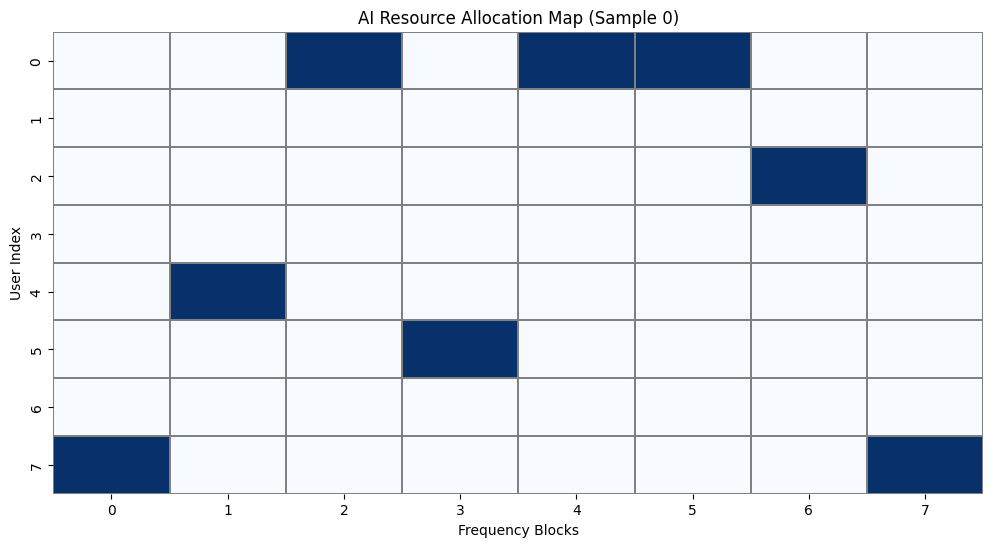

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_allocation(model, loader, patch_cols, device):
    model.eval()
    
    # Get one batch
    batch = next(iter(loader))
    channels = batch[0].to(device)
    
    # 1. Run AI
    # Normalize
    user_pwr = torch.mean(torch.abs(channels)**2, dim=(2,3), keepdim=True)
    user_scale = torch.sqrt(user_pwr + 1e-12)
    channels_norm = channels / user_scale
    
    with torch.no_grad():
        probs, powers = model(channels_norm, temperature=0.01)
        # Allocation Indices (Batch, Blocks)
        alloc_idx = torch.argmax(probs, dim=1).cpu().numpy()
    
    # 2. Plot for Sample 0
    sample_idx = 0
    allocation = alloc_idx[sample_idx] # Shape (Blocks,)
    
    # Create a heatmap grid
    # We want to see which User (Y-axis) gets which Block (X-axis)
    num_users = probs.shape[1]
    num_blocks = probs.shape[2]
    
    grid = np.zeros((num_users, num_blocks))
    
    for b in range(num_blocks):
        u = allocation[b]
        grid[u, b] = 1.0 # User u owns block b
        
    plt.figure(figsize=(12, 6))
    sns.heatmap(grid, cmap="Blues", cbar=False, linewidths=0.1, linecolor='gray')
    plt.title(f"AI Resource Allocation Map (Sample {sample_idx})")
    plt.xlabel("Frequency Blocks")
    plt.ylabel("User Index")
    plt.show()

# Run it
visualize_allocation(full_model, test_loader, 4, DEVICE)